In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
model_path = "/content/drive/My Drive/gpt2-lora-w5h1_2"

In [4]:
!pip install -U peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
from peft import PeftModel, PeftConfig, prepare_model_for_kbit_training
from transformers import AutoTokenizer, AutoModelForCausalLM

# PEFT config 불러오기
peft_config = PeftConfig.from_pretrained(model_path)
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, model_path)  # LoRA weight 적용
model = prepare_model_for_kbit_training(model)

# tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
from transformers import AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType

# 1. 사전학습된 모델 로드
model = AutoModelForCausalLM.from_pretrained("gpt2")

# 2. LoRA 설정
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["c_attn", "c_proj"]  # GPT-2 기준 /
)

# 3. LoRA 적용
model = get_peft_model(model, peft_config)

# 4. 확인
model.print_trainable_parameters()  # ✅ 이 출력이 있어야 학습 가능


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


In [7]:
import pandas as pd

df = pd.read_csv('Academic_Dataset.csv')
df['tone']='academic'
from datasets import Dataset
dataset = Dataset.from_pandas(df)

# format_prompt 함수는 기존과 동일
def format_prompt(example):
    prompt = (
        f"[SCENARIO]\n"
         f"Tone: {example['tone']}\n"
        f"Who: {example['who']}\n"
        f"What: {example['what']}\n"
        f"When: {example['when']}\n"
        f"Why: {example['why']}\n"
        f"How: {example['how']}\n"
        f"Where: {example['where']}\n"
        f"[EXCUSE]\n"
    )
    full = prompt + example["text"]
    tokenized = tokenizer(full, padding="max_length", max_length=256, truncation=True)

    prompt_ids = tokenizer(prompt, truncation=True)["input_ids"]
    full_ids = tokenized["input_ids"]
    labels = [-100] * len(prompt_ids) + full_ids[len(prompt_ids):]
    labels += [-100] * (256 - len(labels))
    tokenized["labels"] = labels[:256]
    return tokenized

tokenized = dataset.map(format_prompt)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./gpt2-lora-w5h1_Academic",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=1,
    save_strategy="epoch",

    save_total_limit=1,
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,              # 이미 LoRA weight가 적용된 모델
    args=training_args,
    train_dataset=tokenized,  # map(format_prompt) 적용된 HuggingFace Dataset
    tokenizer=tokenizer,

)


trainer.train()

train_losses = []
epochs = []

for log in trainer.state.log_history:
    if 'loss' in log.keys():
        train_losses.append(log['loss'])
        epochs.append(log['epoch'])

/tmp/ipython-input-8-2919481603.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,7.575500
2,7.511300
3,7.654100
4,7.989100
5,7.898100
6,7.245300
7,7.053200
8,7.418500
9,7.329700
10,7.239100


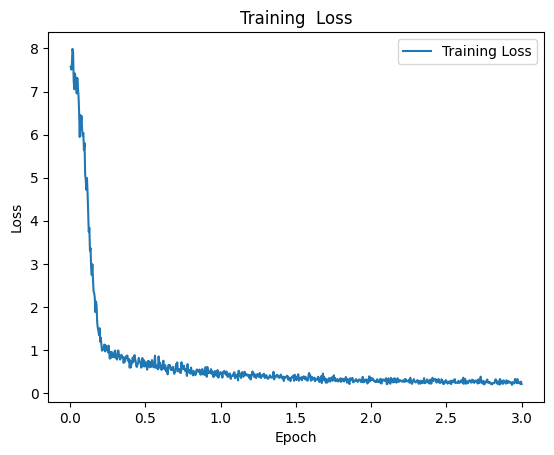

In [12]:
import matplotlib.pyplot as plt

plt.plot(epochs[:len(train_losses)], train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training  Loss")
plt.legend()
plt.show()


In [14]:
#여기서 다시 생성해보기
prompt = (
    "[SCENARIO]\n"
    f"Tone: academic\n"
    f"Who: the junior developer\n"
    f"What: missing the morning team standup\n"
    f"When: earlier today\n"
    f"Where: at the office\n"
    f"Why: setting my alarm for the wrong time.\n"
    f"How: Can we catch up later today?\n"
    "[EXCUSE]\n"
)

# 토크나이즈
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# 생성
output = model.generate(
    **inputs,
    max_length=150,         # 길이 충분히 확보
    do_sample=True,         # 샘플링 모드 (무작위성 포함)
    temperature=0.9,        # 창의성 제어
    top_p=0.95,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id  # 경고 방지
)

# 디코딩
print(tokenizer.decode(output[0], skip_special_tokens=True))

[SCENARIO]
Tone: academic
Who: the junior developer
What: missing the morning team standup
When: earlier today
Where: at the office
Why: setting my alarm for the wrong time.
How: Can we catch up later today?
[EXCUSE]
At the earlier in this year at at the at the office, the managing team failed to resolve the problem arising from setting my alarm for the wrong time. Can we catch up later? Efforts to resolve this matter have been in the consideration of the matter, and thank your patience.


In [11]:
model.save_pretrained("/content/drive/MyDrive/gpt2-lora-w5h1_Academic")
tokenizer.save_pretrained("/content/drive/MyDrive/gpt2-lora-w5h1_Academic")

('/content/drive/MyDrive/gpt2-lora-w5h1_Academic/tokenizer_config.json',
 '/content/drive/MyDrive/gpt2-lora-w5h1_Academic/special_tokens_map.json',
 '/content/drive/MyDrive/gpt2-lora-w5h1_Academic/vocab.json',
 '/content/drive/MyDrive/gpt2-lora-w5h1_Academic/merges.txt',
 '/content/drive/MyDrive/gpt2-lora-w5h1_Academic/added_tokens.json',
 '/content/drive/MyDrive/gpt2-lora-w5h1_Academic/tokenizer.json')